# ClearWater-Riverine Demo 2: Coupling Transport to Water Quality Reactions with ClearWater-Modules

**Objective**: Demonstrate a more complex scenario of coupled transport and reaction models in Sumwere Creek, using the [ClearWater-modules](https://github.com/EcohydrologyTeam/ClearWater-modules) to simulate heat exchange with the atmosphere.

This second notebook builds on the introduction to using [ClearWater-riverine](https://github.com/EcohydrologyTeam/ClearWater-riverine) provided in demo notebook 1.

## Background 
This notebook couples Clearwater-riverine (transport) with Clearwater-modules (reactions) - specifically, the Temperature Simulation Model (TSM). The Temperature Simulation Module (TSM) is an essential component of ClearWater (Corps Library for Environmental Analysis and Restoration of Watersheds). TSM plays a crucial role in simulating and predicting water temperature within aquatic ecosystems. TSM utilizes a comprehensive energy balance approach to account for various factors contributing to heat inputs and outputs in the water environment. It considers both external forcing functions and heat exchanges occurring at the water surface and the sediment-water interface. The primary contributors to heat exchange at the water surface include shortwave solar radiation, longwave atmospheric radiation, heat conduction from the atmosphere to the water, and direct heat inputs. Conversely, the primary factors that remove heat from the system are longwave radiation emitted by the water, evaporation, and heat conduction from the water to the atmosphere. 
The core principle behind TSM is the application of the laws of conservation of energy to compute water temperature. This means that the change in heat content of the water is directly related to changes in temperature, which, in turn, are influenced by various heat flux components. The specific heat of water is employed to establish this relationship. Each term of the heat flux equation can be calculated based on the input provided by the user, allowing for flexibility in modeling different environmental conditions

## Example Case Study

This example shows how to run Clearwater Riverine coupled with Clearwater Modules in a fictional location, "Sumwere Creek" (shown below). The flow field for Sumwere Creek comes from a HEC-RAS 2D model, which has a domain of 200x200 meters and a base mesh of 10x10 meters. 

![image.png](../docs/imgs/SumwereCreek_coarse.png)

The upstream boundary for Sumwere Creek is at the top left of the model domain, flowing into the domain at a constant 3 cms. At the first bend in the creek, there is an additional boundary representing a spring-fed tributary to the creek (1 cms). Further downstream, there is a meander in the stream forming a slow-flowing oxbow lake. There is another boundary flowing into that oxbow lake, representing a powerplant discharge (0.5 cms). 

The downstream boundary is a constant stage set at 20.75  The upstream inflows have a water temperature of 15 degrees C; the spring-fed creek has constant inflows of 5 C, and the powerplant is steady at 20 C with periodic higher temperature (25 C) discharges in a downstream meander.  

We simulate this scenario over the course of two full days, using meteorological parameters from Arizona (extreme temperature swings between night and day) to help show off the impacts of TSM.

### Data Availability
All data required run this notebook is available at this [Google Drive](https://drive.google.com/drive/folders/1I_di8WrK95QwBga-W8iuJaJJMZsnIYSS?usp=drive_link). Please download the entire folder and place it in the `data_temp` folder of this repository to run the rest of the notebook.

## Model Set-Up
### General Imports

In [1]:
from pathlib import Path
import logging
import numpy as np
import pandas as pd
import xarray as xr
#import holoviews as hv
#import geoviews as gv
# from holoviews import opts
#import panel as pn
#hv.extension("bokeh")

### Import ClearWater-riverine
These steps require first completing **[Installation](https://github.com/EcohydrologyTeam/ClearWater-riverine?tab=readme-ov-file#installation)** of a [conda](https://conda.io/docs/) virtual environment customized for the ClearWater-riverine library.

In [2]:
# Find project directory (i.e. the parent to `/examples` directory for this notebook)
project_path = Path.cwd().parent
project_path

WindowsPath('d:/Clearwater/ClearWater-riverine')

In [3]:
# Your source directory should be: 
src_path = project_path / 'src'
src_path

WindowsPath('d:/Clearwater/ClearWater-riverine/src')

Next, we'll need to import Clearwater Riverine. While the package is still under development, the easiest way to do this is to use the [`conda develop`](https://docs.conda.io/projects/conda-build/en/latest/resources/commands/conda-develop.html) command in the console or terminal like this, replacing the `'/path/to/module/src'` with your specific path to the source directory. In other words:
- Copy from the output of `src_path` from the cell above, and 
- Paste it after `!conda develop` in the cell below (replacing the previous user's path). 

NOTE: If your path has any blank spaces, you must enclose the path with quotes.

In [4]:
!conda develop '/Users/aaufdenkampe/Documents/Python/ClearWater-riverine/src'

path exists, skipping d:\Clearwater\ClearWater-riverine\examples\'\Users\aaufdenkampe\Documents\Python\ClearWater-riverine\src'
completed operation for: d:\Clearwater\ClearWater-riverine\examples\'\Users\aaufdenkampe\Documents\Python\ClearWater-riverine\src'


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
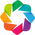

In [5]:
import clearwater_riverine as cwr

### Import ClearWater-Modules

We will also need to install Clearwater Modules' `Energy Budget` module. While this package is also still under development, the best way to install is with `conda develop`. You will need to clone the [ClearWater Modules](https://github.com/EcohydrologyTeam/ClearWater-modules) repository. Then, use conda develop pointing to the path of your `clearwater-modules` folder like below.

NOTE: You will need to find this path yourself. Remember that if your path has any blank spaces, you must enclose the path with quotes.

In [6]:
!conda develop '/Users/aaufdenkampe/Documents/Python/ClearWater-modules/src'

path exists, skipping d:\Clearwater\ClearWater-riverine\examples\'\Users\aaufdenkampe\Documents\Python\ClearWater-modules\src'
completed operation for: d:\Clearwater\ClearWater-riverine\examples\'\Users\aaufdenkampe\Documents\Python\ClearWater-modules\src'


You now need to restart the Python kernel for this notebook, if the path didn't already exist.

In [7]:
from clearwater_modules.nsm1.model import NutrientBudget

## Instantiate Models
### Clearwater-Riverine

Ensure that you have followed the instructions in the Data Availability Section, and that you have all files downloaded in `examples/data_temp/sumwere_creek_coarse_p38`. For a more detailed explanation of all the steps in this process, please see [01_getting_started_riverine.ipynb](./01_getting_started_riverine.ipynb).

In [8]:
network_path = Path(r'W:\2ERDC12 - Clearwater\Clearwater_testing_NSM\plan_48_simulation')
wetted_surface_area_path = network_path / "wetted_surface_area.zarr"
q_solar_path = network_path / 'cwr_boundary_conditions_q_solar_p28.csv'
air_temp_path = network_path / 'cwr_boundary_conditions_TairC_p28.csv'
config_file = network_path / 'demo_config.yml'

In [9]:
#flow_field_fpath.exists()
config_file.exists()

True

In [10]:
start_index =  0 # int((8*60*60)/30)
end_index = 48*60*60
print(start_index, end_index)

0 172800


In [11]:
%%time
transport_model = cwr.ClearwaterRiverine(
    config_filepath=config_file,
    verbose=True,
    datetime_range= (start_index, end_index)
)

Populating Model Mesh...
Calculating Required Parameters...
CPU times: total: 1.41 s
Wall time: 1.82 s


In [12]:
#print(transport_model.constituent_dict)
transport_model.mesh

<xarray.Dataset> Size: 495MB
Dimensions:                 (node: 549, time: 5761, nface: 444, nmax_face: 8,
                             nedge: 915, 2: 2)
Coordinates:
    node_x                  (node) float64 4kB 5.004e+05 5.005e+05 ... 5.024e+05
    node_y                  (node) float64 4kB 2.381e+03 2.376e+03 ... 500.0
  * time                    (time) datetime64[ns] 46kB 2022-05-13 ... 2022-05-15
    face_x                  (nface) float64 4kB 5.005e+05 ... 5.024e+05
    face_y                  (nface) float64 4kB 2.45e+03 2.45e+03 ... 564.4
Dimensions without coordinates: node, nface, nmax_face, nedge, 2
Data variables: (12/34)
    mesh2d                  int32 4B 0
    face_nodes              (nface, nmax_face) int32 14kB 0 1 2 3 ... -1 -1 -1
    edge_nodes              (nedge, 2) int32 7kB 0 1 1 2 2 ... 547 418 548 519
    edge_face_connectivity  (nedge, 2) int32 7kB 0 207 0 208 ... 194 442 329 443
    edges_face1             (nedge) int32 4kB 0 0 0 0 207 ... 366 0 19 194 329
    edges_face2             (nedge) int32 4kB 207 208 1 367 ... 440 441 442 443
    ...                      ...
    DOC                     (time, nface) float64 20MB 1.0 1.0 1.0 ... nan nan
    DIC                     (time, nface) float64 20MB 1.0 1.0 1.0 ... nan nan
    POM                     (time, nface) float64 20MB 1.0 1.0 1.0 ... nan nan
    CBOD                    (time, nface) float64 20MB 1.0 1.0 1.0 ... nan nan
    PX                      (time, nface) float64 20MB 1.0 1.0 1.0 ... nan nan
    Alk                     (time, nface) float64 20MB 1.0 1.0 1.0 ... nan nan
Attributes: (12/13)
    Conventions:                       CF-1.8 UGRID-1.0 Deltares-0.10
    diffusion_coefficient:             0.1
    volume_calculation_required:       False
    face_area_calculation_required:    False
    face_area_elevation_info:          Empty DataFrame\nColumns: []\nIndex: []
    face_area_elevation_values:        Empty DataFrame\nColumns: []\nIndex: []
    ...                                ...
    face_cell_indexes_df:              Empty DataFrame\nColumns: []\nIndex: []
    face_volume_elevation_info:        Empty DataFrame\nColumns: []\nIndex: []
    face_volume_elevation_values:      Empty DataFrame\nColumns: []\nIndex: []
    boundary_data:                     Empty DataFrame\nColumns: []\nIndex: []
    units:                             Metric
    nreal:                             366

The Clearwater Riverine currently has the cell surface area, not the *wetted* cell surface area, as required for TSM. Ultimately, we will work on incorporating this calculation into Clearwater Riverine; however, for the sake of this example, we have the wetted surface areas saved in a zarr. 

In [13]:
wetted_sa = xr.open_zarr(wetted_surface_area_path)
wetted_sa = wetted_sa.compute()

In [14]:
wetted_sa_subset = wetted_sa.isel(time=slice(start_index, end_index+1))

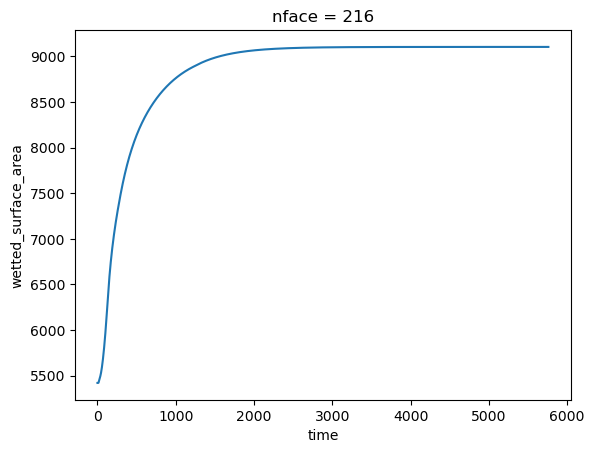

In [15]:
wetted_sa_subset.wetted_surface_area.isel(nface=216).plot()

In [16]:
#transport_model.mesh['wetted_surface_area'] = wetted_sa_subset['wetted_surface_area']

transport_model.mesh['wetted_surface_area'] = xr.DataArray(
    wetted_sa_subset['wetted_surface_area'].values,
    dims=('time', 'nface')
)


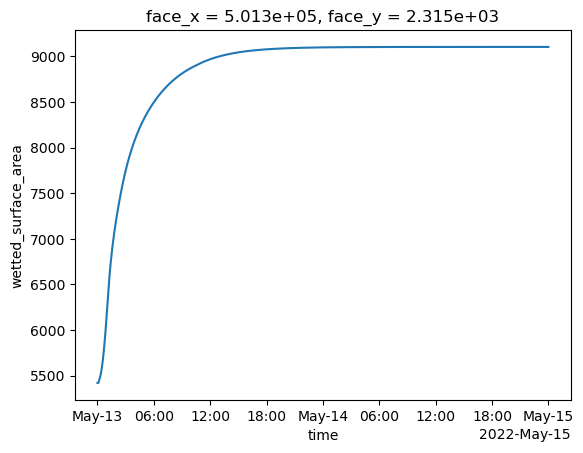

In [17]:
transport_model.mesh.wetted_surface_area.isel(nface=216).plot()

### Clearwater-Modules

#### Initial State Values
The initial state values are `water_temp_c`, `volume`, and `surface_area` come from Clearwater-riverine mesh at the first timestep.

In [18]:
# Provide xr.data array values for initial state values
initial_state_values = {
    'Ap': transport_model.mesh['Ap'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'DOX': transport_model.mesh['DOX'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'NH4': transport_model.mesh['NH4'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'NO3': transport_model.mesh['NO3'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'TIP': transport_model.mesh['TIP'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'Ab': transport_model.mesh['Ab'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'OrgN': transport_model.mesh['OrgN'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'N2': transport_model.mesh['N2'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'OrgP': transport_model.mesh['OrgP'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'POC': transport_model.mesh['POC'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'DOC': transport_model.mesh['DOC'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'DIC': transport_model.mesh['DIC'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'POM': transport_model.mesh['POM'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'CBOD': transport_model.mesh['CBOD'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'PX': transport_model.mesh['PX'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'Alk': transport_model.mesh['Alk'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'volume': transport_model.mesh['volume'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal+1)
    ),
    'surface_area': transport_model.mesh['wetted_surface_area'].isel(
        time=0,
        nface=slice(0, transport_model.mesh.nreal + 1)
    ),
}

#### Meteorological Parameters
The meteorological parameters that we'll be adjusting for this model are `q_solar` and `air_temp_c`. In this example, `q_solar` and `air_temp_c` are pulled from meteorological stations in Arizona. 
We will need to interpolate these datasets to our model timestep, using the following function:

In [19]:
def interpolate_to_model_timestep(meteo_df, model_dates, col_name):
    merged_df = pd.merge_asof(
        pd.DataFrame({'time': model_dates}),
        meteo_df,
        left_on='time',
        right_on='Datetime')
    merged_df[col_name.lower()] = merged_df[col_name].interpolate(method='linear')
    merged_df.drop(
        columns=['Datetime', col_name],
        inplace=True)
    merged_df.rename(
        columns={'time': 'Datetime'},
        inplace=True,
    )
    return merged_df

In [20]:
xarray_time_index = pd.DatetimeIndex(
    transport_model.mesh.time.values
)

Create timeseries of Q solar and Air Temperature aligned with the timestep of the model:

In [21]:
# Q Solar
q_solar = pd.read_csv(
    q_solar_path, 
    parse_dates=['Datetime'])
q_solar.dropna(axis=0, inplace=True)

q_solar_interp = interpolate_to_model_timestep(
    q_solar,
    xarray_time_index,
    'q_Solar'
)

In [22]:
# Air Temperature
air_temp_c = pd.read_csv(
    air_temp_path, 
    parse_dates=['Datetime'])
air_temp_c.dropna(axis=0, inplace=True)

air_temp_c_interp = interpolate_to_model_timestep(
    air_temp_c,
    xarray_time_index,
    'TairC'
)

air_temp_c_interp['air_temp_c'] = (air_temp_c_interp.tairc - 32)* (5/9)

In [23]:
# process for clearwater-modules input
q_solar_array = q_solar_interp.q_solar.to_numpy()
air_temp_array = air_temp_c_interp.air_temp_c.to_numpy()

# for each individual timestep
all_meteo_params = {
    'q_solar': q_solar_array,
    'air_temp_c': air_temp_array,
}

# for initial conditions
initial_meteo_params = {
    'air_temp_c': air_temp_array[0],
    'q_solar': q_solar_array[0],
}

In [24]:
np.shape(air_temp_array)

(5761,)

In [25]:
time_Steps = len(transport_model.mesh.time)
print(time_Steps)
print(type(time_Steps))

5761
<class 'int'>


#### Instantiate Clearwater Modules
We instantiate Clearwater Modules with the following:
* `initial_state_values` (required): our initial conditions of water temperature, cell volumes, and cell surface areas.
* `time_dim` (optional): the model timestep
* `meteo_parameters` (optional): intitial meteorological parameters. If not provided, all meteo parameters will fall to default values.
* `track_dynamic_variables` (optional): boolean indicating whether or not the user wants to track all intermediate information used in the calculations. We set this to `False` to save on memory.
* `use_sed_temp` (optional): boolean indicating whether to use the sediment temperature in TSM calculations. We opt to turn this off for simplicity.
* `updateable_static_variables` (optional): by default, the meteorological variables are static in TSM. If we want these to update over time, we must provide a list of variables that we want to be updateable as input when instantiating the model. 

In [26]:
reaction_model = NutrientBudget(
    time_steps=time_Steps,
    initial_state_values=initial_state_values,
    updateable_static_variables=['q_solar'],
    
    algae_parameters = {
    'AWd': 100,
    'AWc': 40,
    'AWn': 7.2,
    'AWp': 1,
    'AWa': 1000,
    'KL': 10,
    'KsN': 0.04,
    'KsP': 0.0012,
    'mu_max_20': 1,
    'kdp_20': 0.15,
    'krp_20': 0.2,
    'vsap': 0.15,
    'growth_rate_option': 3,
    'light_limitation_option': 1 
    },

    global_parameters={
    'use_NH4': True,
    'use_NO3': True, 
    'use_OrgN': False,
    'use_OrgP': False,
    'use_TIP': True,  
    'use_SedFlux': False,
    'use_DOX': True,
    'use_Algae': True,
    'use_Balgae': False,
    'use_POC': False,
    'use_DOC': False,
    'use_DIC': False,
    'use_N2': False,
    'use_Pathogen': False,
    'use_Alk': False,
    'use_POM': False 
    },


    global_vars = {
    'vson': 0.01,
    'vsoc': 0.01,
    'vsop': 0.01,
    'vs': 0.01,
    'SOD_20': .5,
    'SOD_theta': 1.047,
    'vb': 0.01,
    'fcom': 0.4,
    'kaw_20_user': 0,
    'kah_20_user': 1,
    'hydraulic_reaeration_option': 1,
    'wind_reaeration_option': 1,    
    'dt': 0.0003472222,
    'depth': 1.5,
    'TwaterC': 25,
    'theta': 1.047,
    'velocity': 1,
    'flow': 150,
    'topwidth': 100,
    'slope': .0002,
    'shear_velocity': 0.05334,
    'pressure_atm': 1013.25,
    'wind_speed': 3,
    'q_solar': 500,
    'Solid': 1,
    'lambda0': 0.02,
    'lambda1': 0.0088,
    'lambda2': 0.054,
    'lambdas': 0.056,
    'lambdam': 0.174, 
    'Fr_PAR': 0.47  
    },

    track_dynamic_variables=False, 
    time_dim='seconds'    
    )


Initializing from dicts...


D:\Clearwater\ClearWater-modules\src\clearwater_modules\base.py:223: UserWarning: Variable volume is not a state variable, skipping.
  warnings.warn(
D:\Clearwater\ClearWater-modules\src\clearwater_modules\base.py:223: UserWarning: Variable surface_area is not a state variable, skipping.
  warnings.warn(


Model initialized from input dicts successfully!.


## Couple Models
Optionally, you can log output if you run for a long simulation to track progress.

In [27]:
def setup_function_logger(name):
    logger = logging.getLogger('function_logger')
    handler = logging.FileHandler(f'{name}.log')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.DEBUG)  # Adjust the level based on your needs
    return logger

In [28]:
def run_n_timesteps(
    time_steps: int,
    reaction: NutrientBudget,
    transport: cwr.ClearwaterRiverine,
    meteo_params: dict,
    concentration_update = None,
    logging = True,
    log_file_name='log',
):
    """Function to couple Clearwater Riverine and Modules for n timesteps."""

    # Set up logger
    if logging:
        logger = setup_function_logger(f'{log_file_name}')

    for i in range(1, time_steps):
        if i % 100 == 0:
            status = {
                'timesteps': i,
                'cwr': transport.mesh.nbytes * 1e-9,
                'cwm': reaction.dataset.nbytes*1e-9,
            }
            if logging:
                logger.debug(status)

        # Top of timestep: update transport model using values with output from reaction model, if available
        transport.update(concentration_update)

        # Update state values
        updated_state_values = {
            'Ap': transport.mesh['Ap'].isel(
                time=i,
                nface=slice(0,transport.mesh.nreal+1)
            ), 
            'NH4': transport.mesh['NH4'].isel(
                time=i,
                nface=slice(0,transport.mesh.nreal+1)
            ), 
            'NO3': transport.mesh['NO3'].isel(
                time=i,
                nface=slice(0,transport.mesh.nreal+1)
            ), 
            'TIP': transport.mesh['TIP'].isel(
                time=i,
                nface=slice(0,transport.mesh.nreal+1)
            ), 
            'DOX': transport.mesh['DOX'].isel(
                time=i,
                nface=slice(0,transport.mesh.nreal+1)
            ), 
            'q_solar': transport.mesh.Ap.isel(
                time=i,
                nface=slice(0, transport.mesh.nreal + 1)
            ) * 0 + meteo_params['q_solar'][i],
        }

        # Bottom of timestep: update nutrient budget (NSM1)
        reaction.increment_timestep(updated_state_values)

        # Prepare data for input back into Riverine
        ds = reaction.dataset.copy()
        ds['Ap'] = ds['Ap'].where(
            ~np.isinf(ds['Ap']),
            transport.mesh['Ap'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )            
        ds['Ap'] = ds['Ap'].fillna(
            transport.mesh['Ap'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )


        ds['DOX'] = ds['DOX'].where(
            ~np.isinf(ds['DOX']),
            transport.mesh['DOX'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )            
        ds['DOX'] = ds['DOX'].fillna(
            transport.mesh['DOX'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )


        ds['NH4'] = ds['NH4'].where(
            ~np.isinf(ds['NH4']),
            transport.mesh['NH4'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )            
        ds['NH4'] = ds['NH4'].fillna(
            transport.mesh['NH4'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )


        ds['NO3'] = ds['NO3'].where(
            ~np.isinf(ds['NO3']),
            transport.mesh['NO3'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )            
        ds['NO3'] = ds['NO3'].fillna(
            transport.mesh['NO3'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )


        ds['TIP'] = ds['TIP'].where(
            ~np.isinf(ds['TIP']),
            transport.mesh['TIP'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )            
        ds['TIP'] = ds['TIP'].fillna(
            transport.mesh['TIP'].isel(
                nface=slice(0, transport.mesh.nreal+1),
                time=i
            )
        )


        concentration_update = {"Ap": ds.Ap.isel(seconds=i),
                                "DOX": ds.DOX.isel(seconds=i),
                                "NH4": ds.NH4.isel(seconds=i),
                                "NO3": ds.NO3.isel(seconds=i),
                                "TIP": ds.TIP.isel(seconds=i)
                                }


In [29]:
TIME_STEPS = len(transport_model.mesh.time) - 1 # 5760  # len(transport_model.mesh.time) - 60

In [30]:
TIME_STEPS

5760

In [31]:
%%time
run_n_timesteps(
    TIME_STEPS,
    reaction_model,
    transport_model,
    all_meteo_params,
    logging=True,
)

#zarr_outpath = network_path / 'output.zarr'
#netCDF_outpath = network_path / 'output.nc'
#transport_model.finalize(True, zarr_outpath)
#transport_model.finalize(True, netCDF_outpath)

ValueError: axis 0 index 442 exceeds matrix dimension 367

In [32]:
zarr_outpath = network_path / 'output.zarr'
netCDF_outpath = network_path / 'output.nc'
transport_model.finalize(True, zarr_outpath)
transport_model.finalize(True, netCDF_outpath)

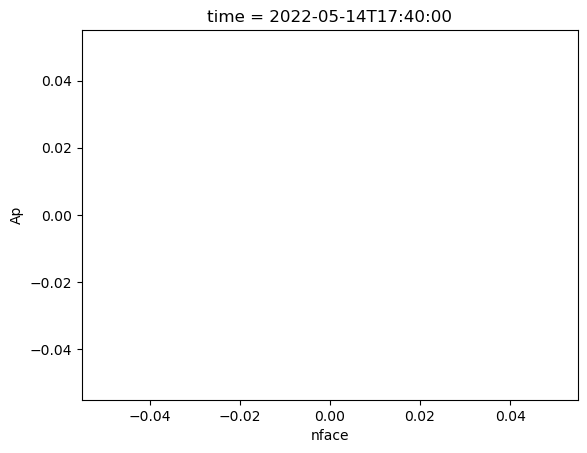

In [33]:
transport_model.mesh.Ap.isel(time=5000).plot()

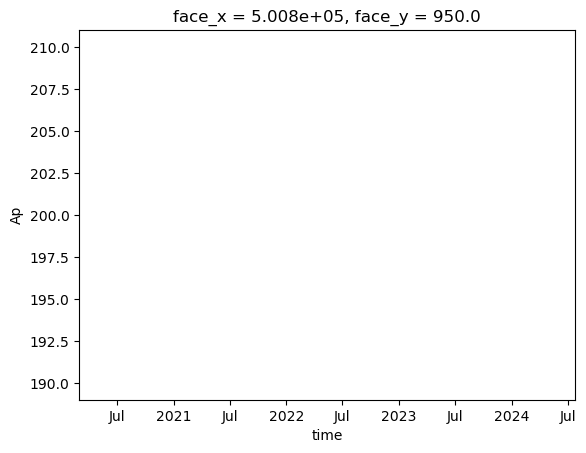

In [34]:
transport_model.mesh.Ap.isel(nface=151).plot()#, time=slice(0, TIME_STEPS)).plot()

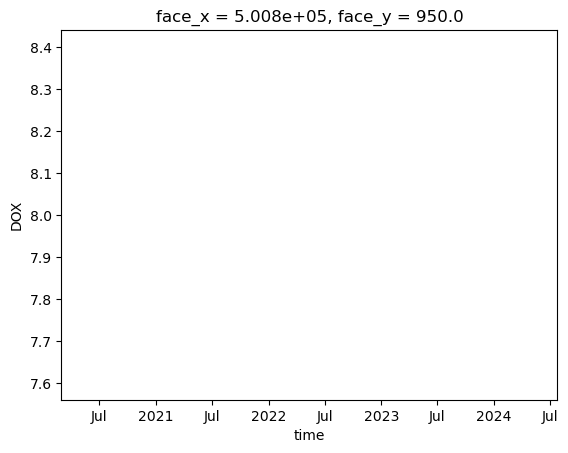

In [35]:
transport_model.mesh.DOX.isel(nface=151, time=slice(0, 5000)).plot()


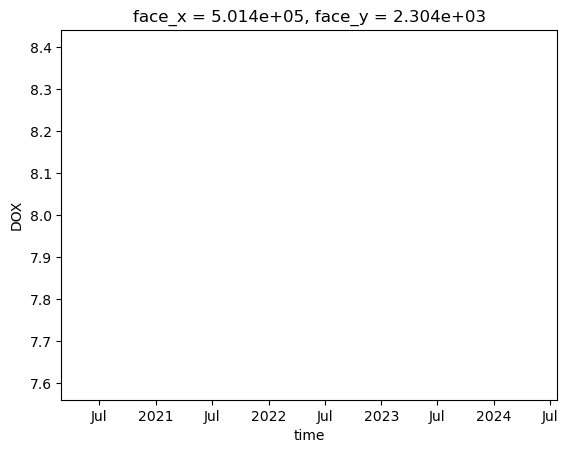

In [36]:
transport_model.mesh.DOX.isel(nface=217, time=slice(0, 5000)).plot()

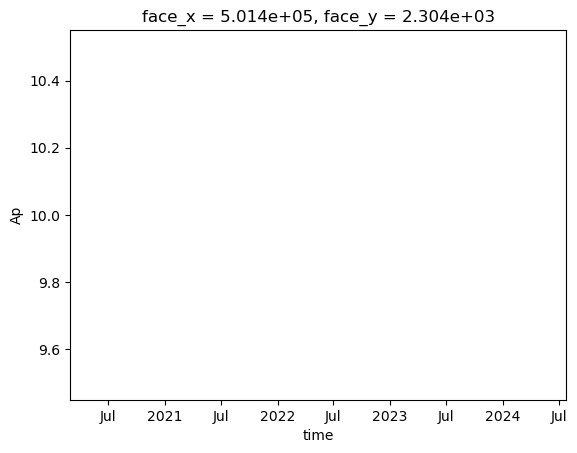

In [37]:
transport_model.mesh.Ap.isel(nface=217, time=slice(0, 5000)).plot()

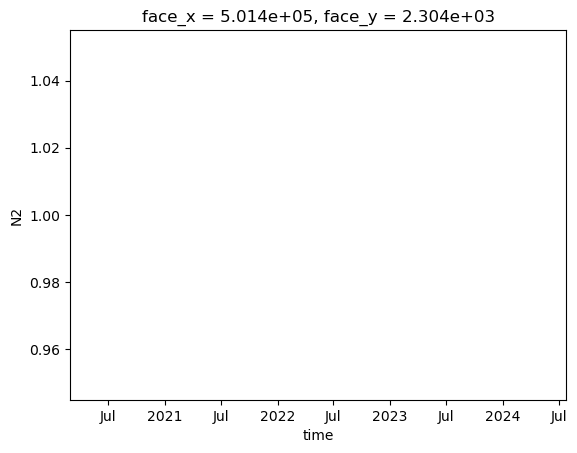

In [38]:
transport_model.mesh.N2.isel(nface=217, time=slice(0, 5000)).plot()

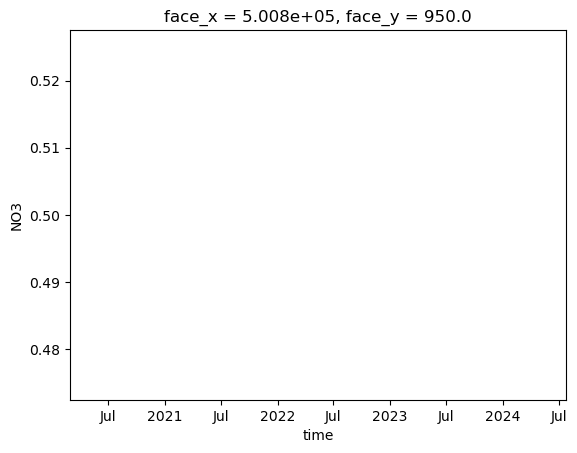

In [39]:
transport_model.mesh.NO3.isel(nface=151, time=slice(0, 5000)).plot()

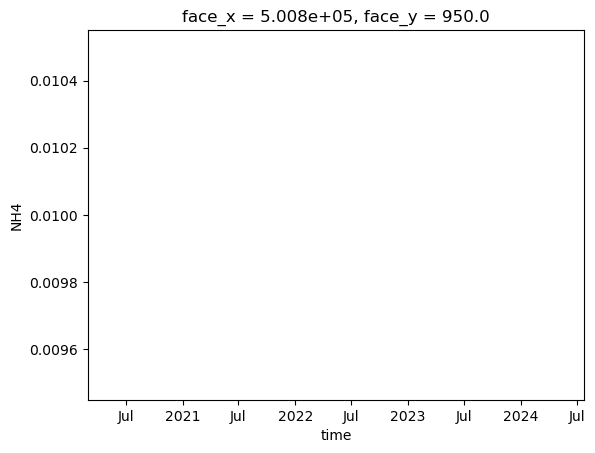

In [40]:
transport_model.mesh.NH4.isel(nface=151, time=slice(0, 5000)).plot()

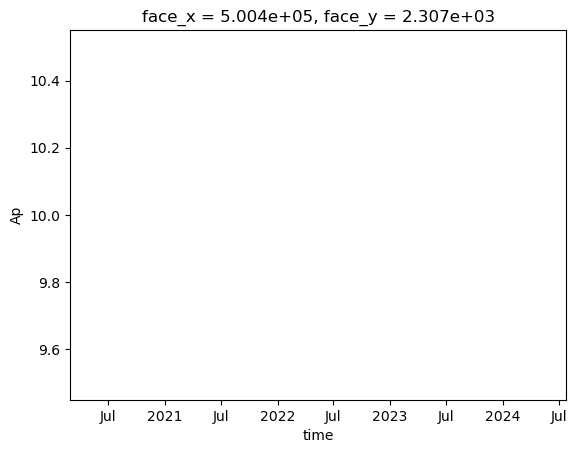

In [41]:
transport_model.mesh.Ap.isel(nface=207, time=slice(0, 5000)).plot()

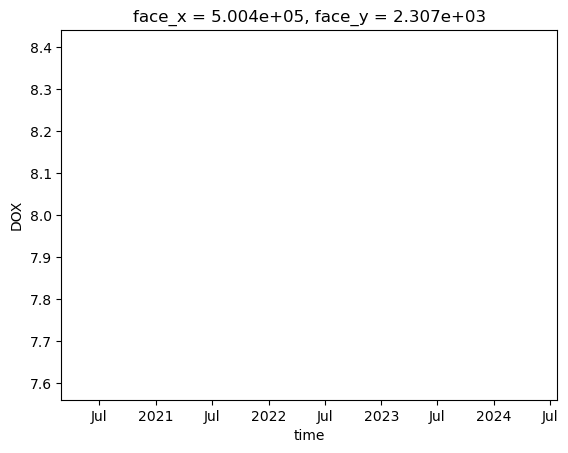

In [42]:
transport_model.mesh.DOX.isel(nface=207, time=slice(0, 5000)).plot()

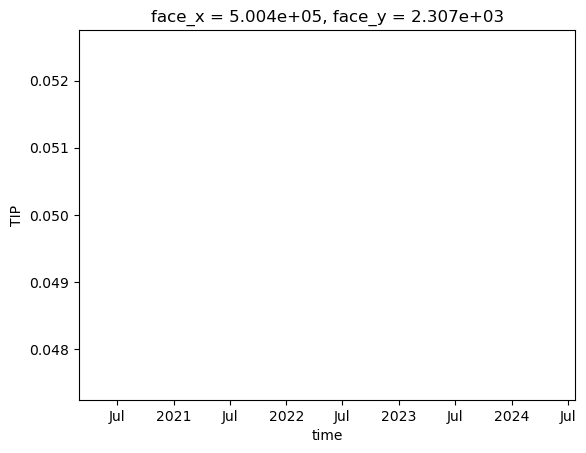

In [43]:
transport_model.mesh.TIP.isel(nface=207, time=slice(0, 5000)).plot()

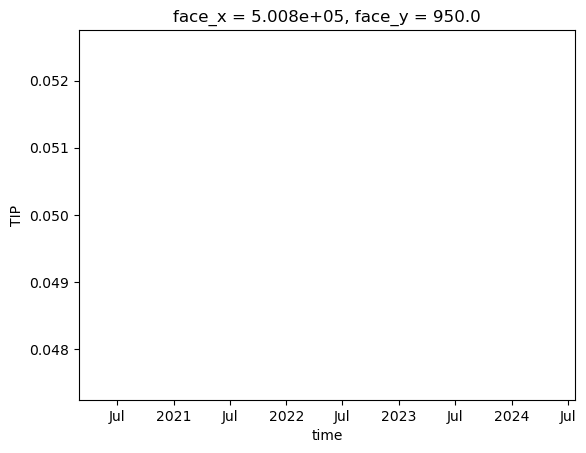

In [44]:
transport_model.mesh.TIP.isel(nface=151, time=slice(0, 5000)).plot()

In [45]:
transport_model.plot(
    crs='EPSG:26916',
    constituent_name='Ap',
    clim=(10, 25),
    cmap='RdYlBu_r',
    filter_empty = True
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'daffa232-5185-485a-9c76-51170f2fdc30': {'version…

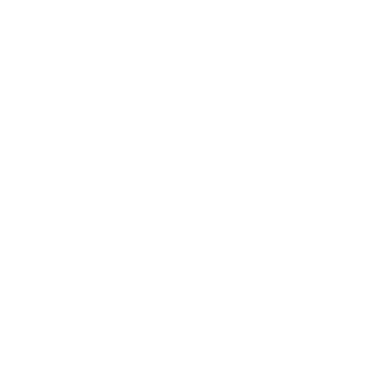

In [46]:
transport_model.static_plot(
    plotting_timestep=1000,
    crs='EPSG:26916',
    constituent_name='Ap',
    clim=(0, 15),
    cmap='RdYlBu_r',
)

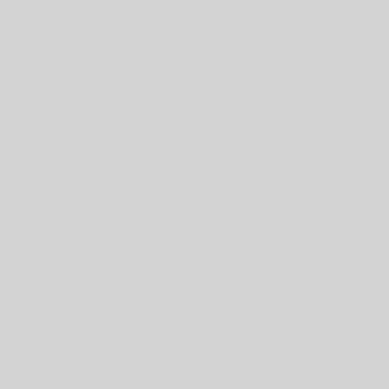

In [47]:
transport_model.static_plot(
    plotting_timestep=5000,
    crs='EPSG:26916',
    constituent_name='Ap',
    clim=(0, 550),
    cmap='RdYlBu_r',
)

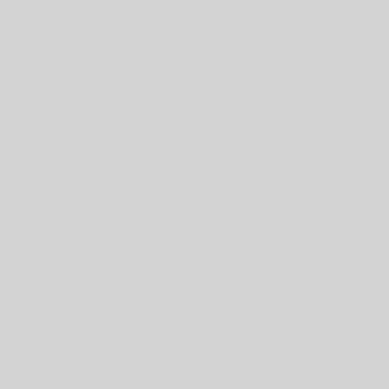

In [48]:
transport_model.static_plot(
    plotting_timestep=1000,
    crs='EPSG:26916',
    constituent_name='DOX',
    clim=(3, 9),
    cmap='RdYlBu_r',
)

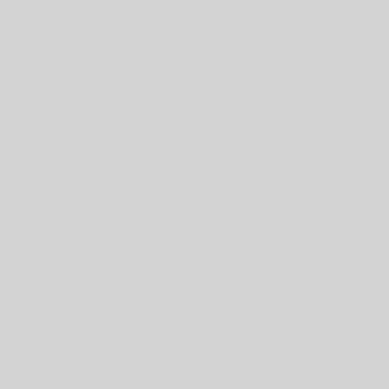

In [49]:
transport_model.static_plot(
    plotting_timestep=1000,
    crs='EPSG:26916',
    constituent_name='NH4',
    clim=(0, 2),
    cmap='RdYlBu_r',
)

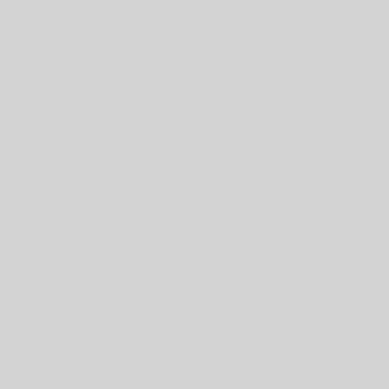

In [50]:
transport_model.static_plot(
    plotting_timestep=1000,
    crs='EPSG:26916',
    constituent_name='NO3',
    clim=(0, 1.25),
    cmap='RdYlBu_r',
)

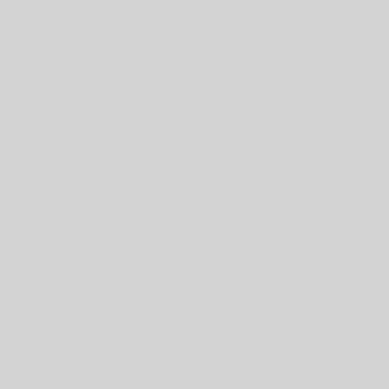

In [51]:
transport_model.static_plot(
    plotting_timestep=5000,
    crs='EPSG:26916',
    constituent_name='TIP',
    clim=(0, 65),
    cmap='RdYlBu_r',
)

In [52]:
transport_model.mesh.temperature.isel(nface=217, time=slice(100, TIME_STEPS)).plot()

AttributeError: 'Dataset' object has no attribute 'temperature'

In [ ]:
transport_model.mesh.temperature.isel(nface=207, time=slice(0, TIME_STEPS)).plot()

In [ ]:
np.shape(transport_model.constituent_dict['temperature'].input_array)

In [ ]:
transport_model.mesh.temperature.isel(nface=165, time=slice(1000, TIME_STEPS)).plot()

## Plot Results

### Built-In Functions
Use the built-in plotting function:

In [ ]:
transport_model.plot(
    crs='EPSG:26916',
    clim=(5, 26)
)

### Build Panel Apps

#### Interactive Timeseries Plotting
This is an exmaple of an interactive map that allows you to click on a single cell and see the timeseries for that cell:

In [ ]:
from clearwater_riverine.variables import (
    NUMBER_OF_REAL_CELLS,
    CONCENTRATION,
)

In [ ]:
# create inputs for panel app
ds = transport_model.mesh
gdf = transport_model.gdf
time_index = 60
mn_val = 4
mval = 25
date_value = ds.time.isel(time=time_index).values

Start by creating a base map of a plan view of Sumwere Creek using the `geoviews` library. Including the `hover` and `tap` tools allows users to hover over the plot to see values and turns on the ability to use the tap stream that allows users to click on a cell and receive feedback from that tap. 

In [ ]:
ras_sub_df = gdf[(gdf.datetime == date_value) & (gdf.concentration != 0)]
units = ds[CONCENTRATION].Units
ras_map = gv.Polygons(
    ras_sub_df,
    vdims=['concentration', 'cell']).opts(
        height = 800,
        width = 800,
        color='concentration',
        cmap='RdYlBu_r',
        line_width = 0.1,
        tools = ['hover', 'tap'],
        clabel = f"Concentration ({units})",
        xaxis=None,
        yaxis=None,
)

The cell below defines the tap stream and initializes an empty list of plots to display. 

In [ ]:
tap_stream = hv.streams.Tap(source=ras_map, x=None, y=None)
plots = []

The `tap_plot` function identifies which cell has been clicked and generates a timeseries plot for that cell.

In [ ]:
def tap_plot(x, y):
    # filter data
    clicked_data = ras_sub_df.cx[x:x, y:y]
    if x != None and y != None:
        # identify cell number and pull concentration timeseries for that cell
        cell = clicked_data['cell'].iloc[0]
        cs = ds.concentration.isel(nface=cell, time=slice(0, TIME_STEPS))

        # Create timeseries plot
        curve = hv.Curve(
            cs,
        ).opts(
            title=f'Time series',
            height=800,
            width=800,
            line_width=5,
            fontsize= {'title': 18, 'labels': 16, 'xticks': 12, 'yticks': 12},
            ylabel= 'Water Temperature (C)'
        )

        # Append to list of plots (allows multiple lines to appear at the same time)
        plots.append(curve)
        # Return an overlay of all the plots
        return hv.Overlay(plots).opts(legend_position='right')
    else:
        # Create an empty timeseries plot telling users to click on a cell to generate a timeseries
        xs = np.linspace(-5,5,100)
        empty_curve = hv.Curve((xs,-(xs-2)**2)).opts(
            title=f'Time series',
            line_color='white',
            height=800, 
            width=800,
            xaxis=None,
            yaxis=None,
        )* hv.Text(0, -20, "Please click a cell on the map to display a timeseries.")
        return empty_curve

# Create Dynamic Map that references the tap stream.
tap_dmap = hv.DynamicMap(tap_plot, streams=[tap_stream])

The following function and button allows users to clear all timeseries plots if they wish to start fresh:

In [ ]:
def reset_tap_stream(event):
    global plots
    tap_stream.event(x=None, y=None)
    plots = []
    
button = pn.widgets.Button(name='Reset', button_type='primary')
button.on_click(reset_tap_stream)

Now display the plot:

In [ ]:
layout = pn.Row(
    ras_map,
    tap_dmap.opts(
        hv.opts.Curve(framewise=True, yaxis='right'),
       ),
    button
    )
layout.servable()

#### Dynamic Map Visualization
Make a plot with a scrubber bar that shows a map over time:

In [ ]:
ds = transport_model.mesh
gdf = transport_model.gdf
import hvplot.pandas 

In [ ]:
# eliminate cells without any temperature
gdf_sub = gdf[gdf.concentration != 0]
gdf_subset = gdf_sub[(gdf_sub['datetime'] > '2022-05-13 08:00:00')]

In [ ]:
plot_to_save = gdf_subset.hvplot(
    geo=True,
    groupby="datetime",
    # z = 'concentration',
    c = 'concentration', # minute_gdf_subset.concentration,
    clim=(4, 25),
    cmap='RdYlBu_r',
    clabel='Water Temperature (C)',
    line_width = 0.1,
    height=700,
    width=800,
    widget_location='bottom',
    line_color='white',
    
)

In [ ]:
plot_to_save